## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, transpile
from qiskit_aer import AerSimulator

from LogicalQ.Logical import LogicalCircuit
from LogicalQ.Library.QECCs import steane_code
from LogicalQ.Library.HardwareModels import hardware_models_Quantinuum
from LogicalQ.Experiments import execute_circuits

%load_ext autoreload
%autoreload 2

## Transverse Ising Model

https://www.science.org/doi/epdf/10.1126/science.1208001

TBF later

## Asymmetric Heisingberg Model

### Optimal Clifford + T approximation
"Optimal ancilla-free Clifford+T approximation of z-rotations" https://arxiv.org/pdf/1403.2975

This paper could be useful in the future if it were extended to x-/y-rotations as well. However, implementation and understanding it seems far more difficult. Also, we do not have the factoring oracle required.

### Solovay-Kitaev Algorithm

In [70]:
from qiskit.transpiler.passes import SolovayKitaev
from qiskit.synthesis import generate_basic_approximations
from qiskit.circuit.library import RXGate, RYGate, RZGate, RXXGate, RYYGate, RZZGate

In [83]:
qc = QuantumCircuit(2)
qc.rx(theta = np.pi/4, qubit = 0)
qc.draw()

┌─────────┐
q_0: ┤ Rx(π/4) ├
     └─────────┘
q_1: ───────────

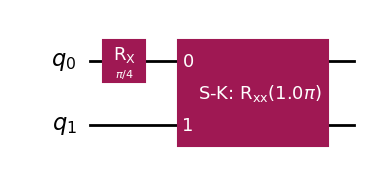

In [84]:
def append_rot_gate(qc, axis = "z", theta = 0, qubit_indices = [0], label = None):
    gates = {"z": (RZGate, 1), "y": (RYGate, 1), "z": (RXGate, 1), "xx": (RXXGate, 2), "yy": (RYYGate, 2), "zz": (RZZGate, 2)}
    gate_base, num_target_qubits = gates[axis]
    gate = gate_base(theta)
    
    sub_qc = QuantumCircuit(num_target_qubits)
 
    def apply_Rzz(sub_qc):
        sub_qc.cx(0, 1)
        sub_qc.rz(theta, 1)
        sub_qc.cz(0, 1)
 
    match axis:
        case "xx":
            sub_qc.h([0, 1])
            apply_Rzz(sub_qc)
            sub_qc.h([0, 1])
        case "yy":
            sub_qc.rx(np.pi / 2, [0, 1])
            apply_Rzz(sub_qc)
            sub_qc.rx(-np.pi / 2, [0, 1])
        case "zz":
            apply_Rzz(sub_qc)
        case _:        
            sub_qc.append(gate, qargs = list(range(num_target_qubits)))
    
    basis = ["s", "sdg", "t", "tdg", "h", "z"] #"x", "y", "z", "cx", "cy", "cz"]
    approx = generate_basic_approximations(basis, depth=3)
    skd = SolovayKitaev(recursion_degree=2, basic_approximations=approx)

    discretized_sub_qc = skd(sub_qc)
    box_label = fr"S-K: R$_\text{{{axis}}}$({np.round(theta / np.pi, 2)}$\pi$)" if label == None else label
    if isinstance(qc, LogicalCircuit):
        with qc.box(label="logical.logicalop.R:{box_label}"):
            for i in range(len(sub_qc.data)):
                circuit_instruction = discretized_sub_qc.data[i]
                qc.append(circuit_instruction)
    elif isinstance(qc, QuantumCircuit):
        sub_gate = discretized_sub_qc.to_gate(label=box_label)
        qc.append(sub_gate, qubit_indices)
    else:
        raise AssertionError("qc is not a valid QuantumCircuit or LogicalCircuit.")
    return qc, discretized_sub_qc

qc, sub_qc = append_rot_gate(qc, "xx", np.pi, [0, 1])
qc.draw(output="mpl")

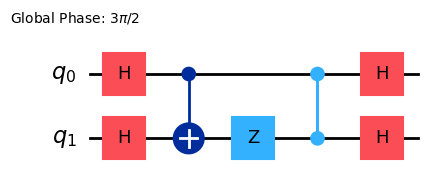

In [85]:
sub_qc.draw(output="mpl")

### Rxx, Ryy, Rzz Gate Validations

In [107]:
from qiskit.quantum_info import Statevector
from qiskit.primitives import StatevectorSampler
sampler = StatevectorSampler()

ratio = 7 / 33 # picked a weird fraction of pi to make the test more robust

Rzz_ref = QuantumCircuit(2)
Rzz_ref.rzz(ratio * np.pi, 0, 1)

state = Statevector.from_instruction(Rzz_ref)
state.draw(output="latex")

<IPython.core.display.Latex object>

In [ ]:
Rzz_alg = QuantumCircuit(2)
Rzz_alg, _ = append_rot_gate(Rzz_alg, "zz", ratio * np.pi, qubit_indices=[0,1])

state = Statevector.from_instruction(Rzz_ref)
state.draw(output="latex")

<IPython.core.display.Latex object>

In [112]:
ratio = 15 / 33 # picked a weird fraction of pi to make the test more robust

Rxx_ref = QuantumCircuit(2)
Rxx_ref.rxx(ratio * np.pi, 0, 1)

state = Statevector.from_instruction(Rxx_ref)
state.draw(output="latex")

<IPython.core.display.Latex object>

In [113]:
Rxx_alg = QuantumCircuit(2)
Rxx_alg, _ = append_rot_gate(Rxx_alg, "xx", ratio * np.pi, qubit_indices=[0,1])

state = Statevector.from_instruction(Rxx_ref)
state.draw(output="latex")

<IPython.core.display.Latex object>

In [114]:
ratio = 19 / 33 # picked a weird fraction of pi to make the test more robust

Ryy_ref = QuantumCircuit(2)
Ryy_ref.rxx(ratio * np.pi, 0, 1)

state = Statevector.from_instruction(Ryy_ref)
state.draw(output="latex")

<IPython.core.display.Latex object>

In [115]:
Ryy_alg = QuantumCircuit(2)
Ryy_alg, _ = append_rot_gate(Ryy_alg, "yy", ratio * np.pi, qubit_indices=[0,1])

state = Statevector.from_instruction(Ryy_ref)
state.draw(output="latex")

<IPython.core.display.Latex object>

### Matching paper results

We are going to initialize our 2-qubit system in the $\frac{1}{\sqrt{5}}(\ket{\uparrow}+2\ket{\downarrow})\otimes \ket{\downarrow}$ state, and then graph expectation values and fidelity as a function of $\theta$.

In [ ]:
def Hxy(dt, J):
    theta = dt * J
    
    qc = QuantumCircuit(2)
    qc = append_rot_gate(qc, "xx", theta, [0, 1])
    qc = append_rot_gate(qc, "yy", theta, [0, 1])
    return qc.to_gate(label="$H_{xy}$")

qc_test = QuantumCircuit(2)
qc_test.append(Hxy(1.0, np.pi), [0,1])
qc_test.draw(output="mpl")

In [ ]:
def get_heisenberg_model_circuit(dt, J):
    qc = QuantumCircuit(2)
    Hxy_box = Hxy(dt, J)
    qc = 0
    pass